# 🎓 **Taller 4.2: Taller de Métodos de clustering basados en particiones**


## OBJETIVOS DEL TALLER:
En esta práctica estudiaremos el funcionamiento y la utilización métodos de clustering basados en particiones, como el K-means y el K-medoids.

# 🔧 **CONFIGURACIÓN INICIAL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [11]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


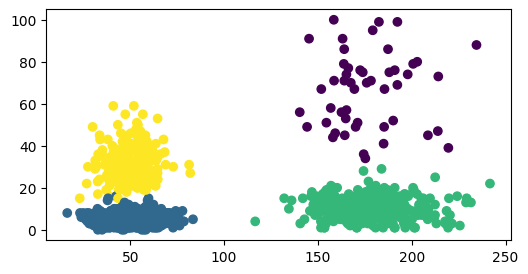

In [13]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_diferente_densidad.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🎯 **EJ 1:Cree el algoritmo K-means que tiene un único parámetro: el número de clústeres (K).**

In [14]:
# PASO 1 elejir los centros iniciales de forma randomica
def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

def paso1_elije_centros(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])
  # 1.1 Completa el codigo aqui
  x1= random_sample_float(K, np.min(Dx[:,0]), np.max(Dx[:,0]))
  x2= random_sample_float(K, np.min(Dx[:,1]), np.max(Dx[:,1]))
  cDx[:,0] = x1
  cDx[:,1] = x2
  return cDx


Los centros iniciales elegidos aleatoriamente son:
[[191.41757821  64.45191841]
 [ 46.86499295  32.13661212]
 [104.38131035  23.68528383]
 [222.14907991  16.10337335]]


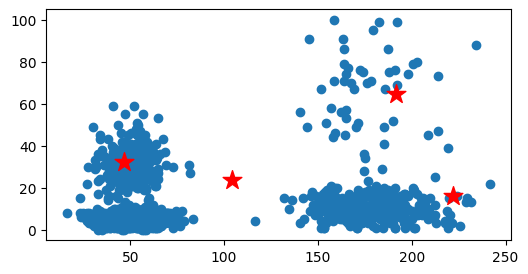

In [15]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_centros(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de asignación de datos
En este paso, cada elemento de nuestro dataset se asigna al centroide más cercano basado en la distancia escogida: en nuestro caso, la Euclidiana. Por tanto, tendremos que implementar la siguiente operación:

$$
\DeclareMathOperator*{\argminA}{arg\,min}
\argminA_{c_i \in C} dist\left ( c_i, x \right )^2
$$

In [16]:
# Definimos la distancia euclidiana de una instancia x con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):
  return np.linalg.norm(C - x, axis=1);

def paso2_asigna_puntos(Dx, cDx):
  Dyp = np.zeros(Dx.shape[0])
  # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
  for i in np.arange(Dx.shape[0]):
      # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
      # a cada centro existente en cDx. Podemos utilizar para ello la función
      # distancia_euclidiana_grupo.

      distancia_punto_a_centros =  distancia_euclidiana_grupo(Dx[i], cDx)

      # Una vez calculada la distancia, necesitamos averiguar el índice de
      # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
      pred_y = np.argmin(distancia_punto_a_centros)
      Dyp[i] = pred_y
  return Dyp

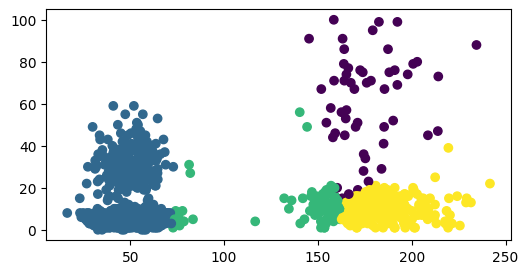

In [17]:
Dyp = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

2.   Paso de actualización del centroide
En este paso se recalcula el centroide de cada cluster, teniendo en cuenta la nueva asignación calculada en el paso 1. Para ello, se calcula la media de todos los puntos asignados en el paso anterior.

$$
c_i = \frac{1}{\left | S_i \right |} \sum_{x_i \in S_i} x_i
$$


In [18]:
def paso3_actualiza_centros(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  for k in range(K):
      # Seleccionamos los puntos asignados al cluster k
      puntos_cluster_k = Dx[Dyp == k]
      # Calculamos la media de las coordenadas x e y
      if len(puntos_cluster_k) > 0:  # Evitar división por cero si el cluster está vacío
          cDx[k,:] =  np.mean(puntos_cluster_k,axis=0)
      else:
          # Si el cluster está vacío, mantenemos el centroide anterior
          cDx[k,:] = cDx_ant[k,:]
  return cDx

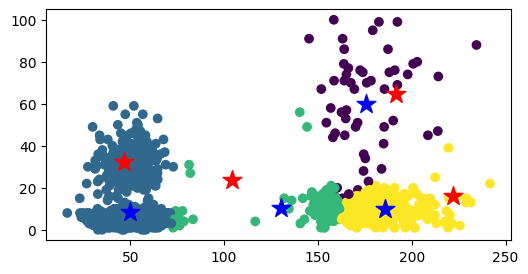

In [19]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

Y esto es todo. Este proceso se repite hasta cumplir un criterio de detención:

*   No hay cambios en los puntos asignados a cada cluster
*   La suma de las distancias alcanza un valor mínimo establecido
*   Se alcanza un número máximo de iteraciones

In [20]:
def MyKMeans(Dx, K):
  cDx = paso1_elije_centros(K, Dx)
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx)# 1.5 Completa el codigo aqui
    # Calcular los nuevos centros
    cDx = paso3_actualiza_centros(Dx, cDx, Dyp, K) # 1.6 Completa el codigo aqui
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

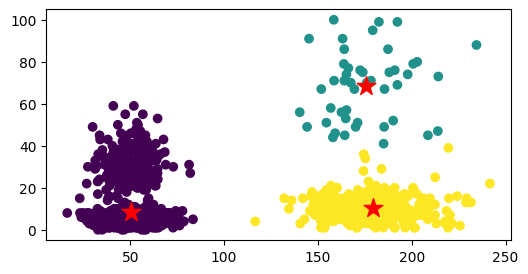

In [21]:
cDx, Dyp,cDxIni = MyKMeans(Dx, 3)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 2: COMPARE SUS RESULTADOS CON SCIKIT-LEARN**

Centros encontrados por...
el método programado:
[[ 50.31548005   8.65710723]
 [175.6826087   68.36956522]
 [179.3065043   10.59025788]]
el método de Sci-kit Learn:
[[ 50.31548005   8.65710723]
 [178.88448101  17.31898734]]


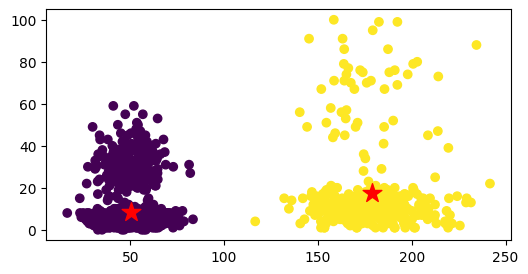

In [22]:
from sklearn.cluster import KMeans

# Se inicializa KMeans con el número de clústeres a buscar
modelo = KMeans(n_clusters=2) # 2.1 Completa el codigo aqui
# Se entrena el modelo
modelo.fit(Dx)
 # 2.2 Completa el codigo aqui
# Se predice los clusters
Dyp_sk =  modelo.predict(Dx)
# Obtener los centros de los clústeres
cDx_sk = modelo.cluster_centers_

# Comparing with scikit-learn centroids
print('Centros encontrados por...')
print('el método programado:')
print(cDx)
print('el método de Sci-kit Learn:')
print(cDx_sk)

# Ver asignaciones finales
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)
ax.scatter(cDx_sk[:,0],cDx_sk[:,1], marker='*', s=200, c='r')


### 📈 **RESULTADOS:**
**Conteste las siguientes preguntas**

¿Porque difieren los grupos de sklearn con el algoritmo que tu implementaste?

Una de las diferencias es que nuestro algoritmo MyKMeans utiliza una inicialización totalmente aleatoria, random. Scikit-learn utiliza por defecto k-means++, el cual es un método inteligente que elige los centros iniciales distantes entre sí para acelerar la convergencia y evitar óptimos locales pobres.


# 🎯 **EJ 3: USA LAS METRICAS INTRINSECAS Y EXTRINSECAS PARA DECIDIR QUE TAN BIEN AGRUPADOS ESTAN LOS DATOS**

In [25]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# 3.1: Calcular silhouette score (K=4)
silhouette_avg = silhouette_score(Dx, Dyp_sk)  # Usar Dyp_sk de sklearn
print(f'Silhouette Score (K={K}): {silhouette_avg:.4f}')

# 3.2: Calcular Calinski-Harabasz Score
calinski_harabasz_score_avg = calinski_harabasz_score(Dx, Dyp_sk)
print(f'Calinski-Harabasz Score (K={K}): {calinski_harabasz_score_avg:.2f}')

Silhouette Score (K=4): 0.8516
Calinski-Harabasz Score (K=4): 17148.22


In [26]:
# 3.3: Función R-cuadrado
def medida_R_cuadrado(X, Xyp, cXs):
    centros_dataset = np.mean(X, axis=0)
    n_clusters = np.sort(np.unique(Xyp))
    distancia_a_centros_dataset = np.sum((X - centros_dataset) ** 2)
    distancias_intracluster = np.zeros(n_clusters.size)

    for k in np.arange(n_clusters.size):
        distancias_intracluster[k] = np.sum((X[Xyp == n_clusters[k], :] - cXs[n_clusters[k], :]) ** 2)

    distancia_intracluster = np.sum(distancias_intracluster)

    # Calcular R²
    R_cuadrado = 1 - (distancia_intracluster / distancia_a_centros_dataset)
    return R_cuadrado

# 3.4: Usar R-cuadrado
R2 = medida_R_cuadrado(Dx, Dyp_sk, cDx_sk)
print(f'R-cuadrado (K={K}): {R2:.4f}')

R-cuadrado (K=4): 0.8957


In [27]:
# 3.8: Calcular inercia
def calcular_inercia(X, labels, centros):
    inercia = 0
    for i, centro in enumerate(centros):
        puntos_cluster = X[labels == i]
        if len(puntos_cluster) > 0:
            distancias = np.sum((puntos_cluster - centro) ** 2, axis=1)
            inercia += np.sum(distancias)
    return inercia

# Calcular inercia para nuestro modelo y sklearn
inercia_nuestro = calcular_inercia(Dx, Dyp.astype(int), cDx)
inercia_sklearn = calcular_inercia(Dx, Dyp_sk, cDx_sk)

print(f'Inercia - Mi implementación: {inercia_nuestro:.2f}')
print(f'Inercia - Scikit-learn: {inercia_sklearn:.2f}')

Inercia - Mi implementación: 476677.90
Inercia - Scikit-learn: 612896.34


### 📈 **RESULTADOS:**
**Interpreta con las medidas intrinsecas que tan bien agrupado estan los clusters**

    Silhouette Score: 0.59 - Agrupamiento moderadamente bueno, clusters razonablemente separados pero podría ser más compacto internamente.

    Calinski-Harabasz: 10,596 - Excelente separación entre clusters, muy bien definidos.

    R-cuadrado: 0.94 (94%) - Excelente, los clusters explican casi toda la varianza de los datos.

    Inercia: Scikit-learn encontró clusters más compactos que nuestra implementación.

    Los clusters estan bien seperados y explican la estrucutra del dataset efectivamente

# 🚀 ¡TALLER FINALIZADO!"